In [1]:
import pandas as pd
from apriori import Apriori
import statistics
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
from functools import reduce

In [2]:
original_store_data = pd.read_csv("../Dataset/SampleSuperstore.csv")

In [3]:
print(original_store_data.shape)
original_store_data.head()

(9994, 13)


,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


In [4]:
print(original_store_data['Ship Mode'].unique())
print(original_store_data['Segment'].unique())
print(original_store_data['Country'].unique())
print(original_store_data['Category'].unique())
print(original_store_data['Sub-Category'].unique())

['Second Class' 'Standard Class' 'First Class' 'Same Day']
['Consumer' 'Corporate' 'Home Office']
['United States']
['Furniture' 'Office Supplies' 'Technology']
['Bookcases' 'Chairs' 'Labels' 'Tables' 'Storage' 'Furnishings' 'Art'
 'Phones' 'Binders' 'Appliances' 'Paper' 'Accessories' 'Envelopes'
 'Fasteners' 'Supplies' 'Machines' 'Copiers']


In [5]:
algorithm = Apriori()
try:
    algorithm.valid_input_check(original_store_data)
except:
    print("The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class")

The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class


#### Changing to a suitable dataframe

In [6]:
store_data = original_store_data[['Postal Code', 'Sub-Category', 'Quantity']]
store_data = store_data.groupby(['Postal Code', 'Sub-Category']).sum()
# Convert quantities to 0/1
store_data['Quantity'] =  (store_data['Quantity']>0).astype(int)
# pivot table and convert it to sparse data
pivoted_store_data = store_data.pivot_table(index='Postal Code', columns='Sub-Category', values='Quantity', fill_value=0)
sparse_store_data = pivoted_store_data.astype(pd.SparseDtype(int, fill_value=0))

In [7]:
print(sparse_store_data.shape)
sparse_store_data.head()

(631, 17)


Sub-Category,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
Postal Code,,,,,,,,,,,,,,,,,
1040,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0
1752,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1810,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
1841,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1


In [8]:
try:
    algorithm.valid_input_check(sparse_store_data)
except:
    print("The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class")

## Apriori Algorithm and extract frequent items as features 

In [9]:
# check for the mean occurence for each combination 
item_count = algorithm.apriori(df=sparse_store_data, use_colnames=True, verbose=1, count=True, min_support=0.001)

Processing 74256 combinations | Sampling itemset size 6

Processing 17 combinations | Sampling itemset size 176531


In [10]:
# 2^^17 
print(f"Total number of combinations of all itemsets: {len(item_count)}")
average_occurence = round(sum(item_count['count'])/len(item_count), 2)
median_occurence = statistics.median(item_count['count'])
percentile_99 = np.percentile(item_count['count'], 99.9)
print(f"Average Occurence of each combination: {average_occurence}")
print(f"Median Occurence of each combination: {median_occurence}")
print(f"99.9 Percentile Occurence of each combination: {percentile_99}")

Total number of combinations of all itemsets: 131071
Average Occurence of each combination: 26.62
Median Occurence of each combination: 23.0
99.9 Percentile Occurence of each combination: 128.0


In [11]:
# We define frequent item as those that occur more than the average occurence
frequent_items = list(item_count[item_count['count']>percentile_99]['itemsets'])
len(frequent_items)

131

In [12]:
new_col = frequent_items

### Data Preprocessing for Clustering Users

In [13]:
new_df = pd.DataFrame(index=sparse_store_data.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data.index:
        for item in itemset:
            if sparse_store_data.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

  0%|          | 0/131 [00:00<?, ?it/s]

100%|██████████| 131/131 [00:56<00:00,  2.30it/s]


In [14]:
# Adding Label to the new table with frequent items as features
final_df = new_df.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
"""
Combining label if multiple labels are found for the same Postal Code
eg: Postal 123 contains different transactions(rows) with different 'Segment' --> consumer and corporate, 
    it will be combined to one row with 'Segment' --> consumer, corporate
"""
final_df = final_df.groupby('Postal Code').agg({
    **{col: 'max' for col in final_df.columns if col not in ['Postal Code', 'Segment']},
    'Segment': lambda x: ', '.join(sorted(set(x)))
}).reset_index()
final_df.rename(columns={"Segment": "Label"}, inplace=True)

In [15]:
# Label Transform the Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df['Label'] = le.fit_transform(final_df['Label'])

In [16]:
print(f"Number of unique Labels: {len(final_df['Label'].unique())}")

Number of unique Labels: 7


In [17]:
# final_df.to_csv("../Result/SuperStoreFrequentFeatures1.csv")
print(final_df.shape)
final_df.head()

(631, 133)


,Postal Code,(Accessories),(Appliances),(Art),(Binders),(Bookcases),(Chairs),(Envelopes),(Fasteners),(Furnishings),...,"(Binders, Storage, Paper, Art)","(Binders, Storage, Art, Phones)","(Phones, Paper, Art, Furnishings)","(Binders, Chairs, Paper, Furnishings)","(Binders, Paper, Phones, Furnishings)","(Binders, Storage, Paper, Furnishings)","(Binders, Storage, Phones, Furnishings)","(Binders, Storage, Paper, Phones)","(Phones, Storage, Paper, Furnishings)",Label
0,1040,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,1453,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1752,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1810,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1841,0,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,2


### Data Preprocessing for Clustering Items

In [18]:
# new_df = pd.DataFrame(index=sparse_store_data.columns)
# new_df[new_col] = 1
# for itemset in tqdm(new_col):
#     for item in sparse_store_data.columns:
#         if item not in itemset:
#             new_df.at[item, itemset] = 0

# final_df2 = new_df.merge(original_store_data[['Sub-Category', 'Category']], how='left', on='Sub-Category').set_index('Sub-Category').drop_duplicates(keep='first')
# final_df2.rename(columns={"Category": "Label"}, inplace=True)

# le = LabelEncoder()
# final_df2['Label'] = le.fit_transform(final_df2['Label'])

# print(f"Number of unique Labels: {len(final_df2['Label'].unique())}")

# print(final_df2.shape)
# final_df2.head()

len(original_store_data['Sub-Category'].unique())

17

given that there are only 17 items to categorized, decide not to do it

## Clustering Different Users (based on postal code)

### DBSCAN

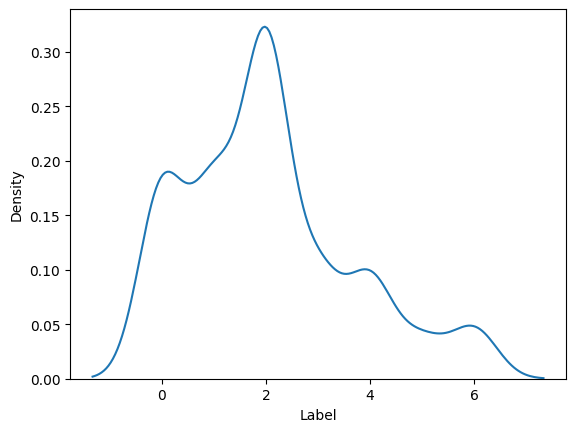

In [19]:
sb.kdeplot(final_df['Label'])
plt.show()

the lowest density of a group is roughly 0.045, which translates to 631*0.045 = 28 points a group

In [20]:
X = final_df.iloc[:, :-1]
X= X.rename(str,axis="columns") 

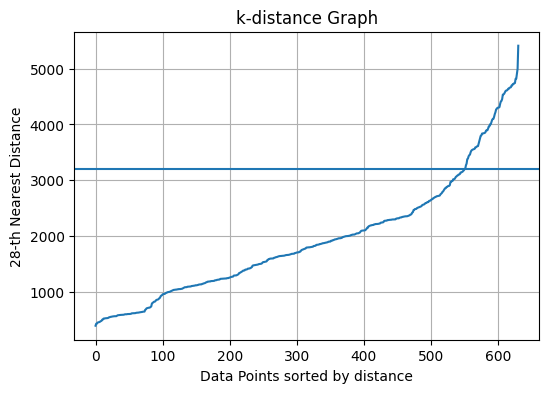

In [21]:
from sklearn.neighbors import NearestNeighbors

minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(3200)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 3200

In [22]:
from sklearn.cluster import DBSCAN

min_samples_ = [20, 25, 30, 35, 40, 45, 50, 55, 60]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=3200, min_samples=i).fit(X)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 4
For min_samples: 30 Number of Clusters Predicted: 5
For min_samples: 35 Number of Clusters Predicted: 6
For min_samples: 40 Number of Clusters Predicted: 7
For min_samples: 45 Number of Clusters Predicted: 6
For min_samples: 50 Number of Clusters Predicted: 6
For min_samples: 55 Number of Clusters Predicted: 5
For min_samples: 60 Number of Clusters Predicted: 6


In [23]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X, cluster.labels_))
    db_.append(davies_bouldin_score(X, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

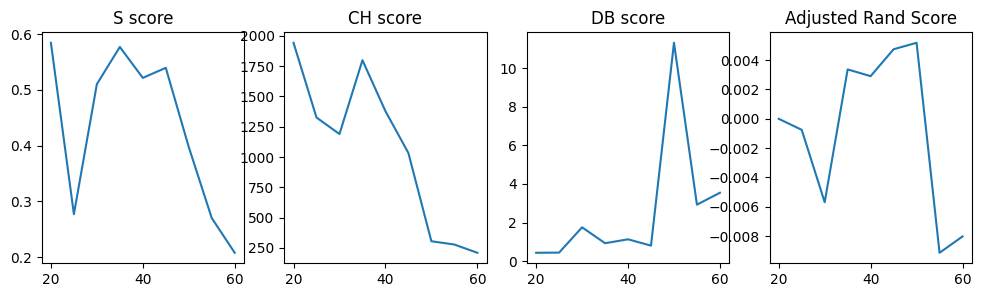

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

eps = 3200  and min_samples = 45 provides the second highest adjusted rand score, relatively high S score and relatively low DB score. 

In [25]:
final_dbscan = DBSCAN(eps=3200, min_samples=45).fit(X)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.5394624574567182
Calinski Harabasz Score: 1032.4551933508928
Davies Bouldin Score: 0.8074351174093229
Adjusted Rand Index: 0.004734365656700725


In [26]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  6


#### Reducing dimension with PCA for visualization of results

In [27]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
X_pc = pd.DataFrame(pca.transform(X))

0.9999999871934689


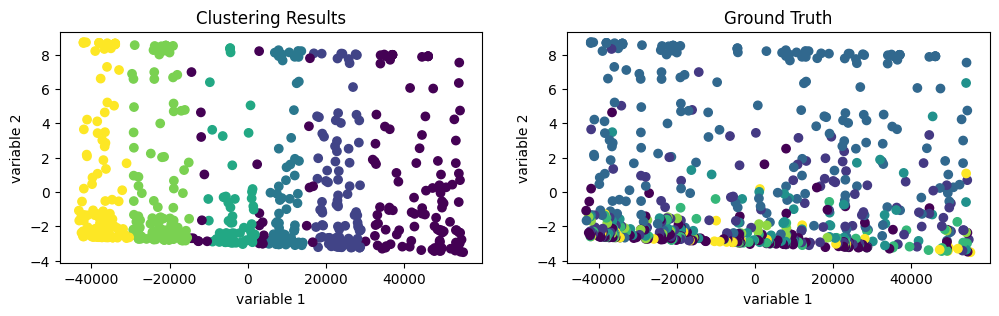

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=dbscan_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
plt.show()

### KMeans

In [29]:
from sklearn.cluster import KMeans

n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X)
    kmeans_.append(kmeans)

In [30]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X, cluster.labels_))
    db_.append(davies_bouldin_score(X, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

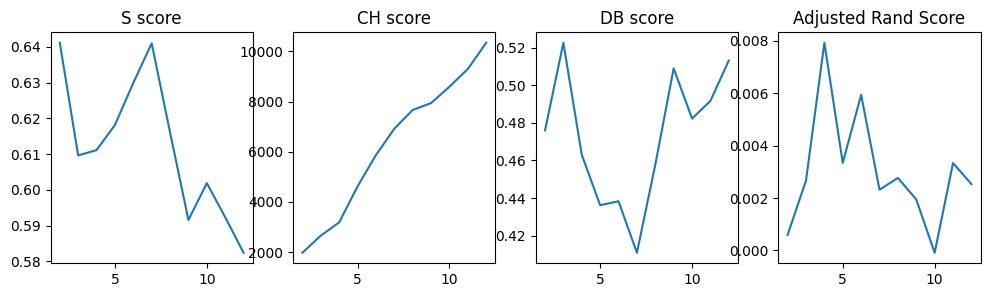

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 4 provides the highest Adjusted Rand Score, relatively high S Score and relatively low DB Score. 

In [32]:
final_kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(X)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.6111147856317314
Calinski Harabasz Score: 3182.492260839047
Davies Bouldin Score: 0.4630063806434899
Adjusted Rand Index: 0.007922750053569605


#### Reducing dimension with PCA for visualization of results

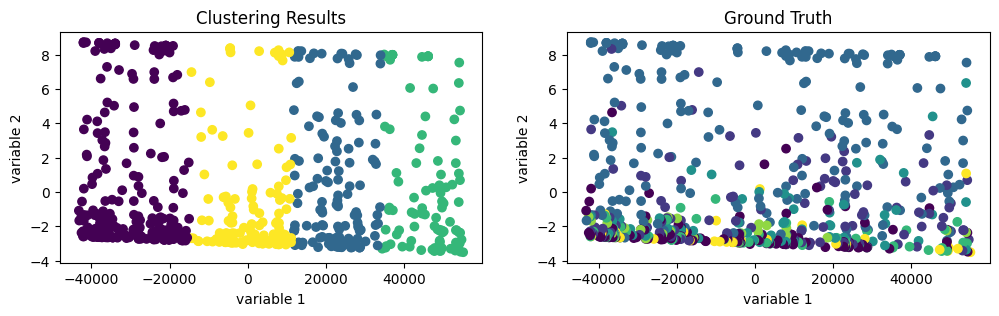

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
plt.show()

## Clustering Different Users (based on postal code) with PCA

In [34]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
X_pc = pd.DataFrame(pca.transform(X))

0.9999999871934689


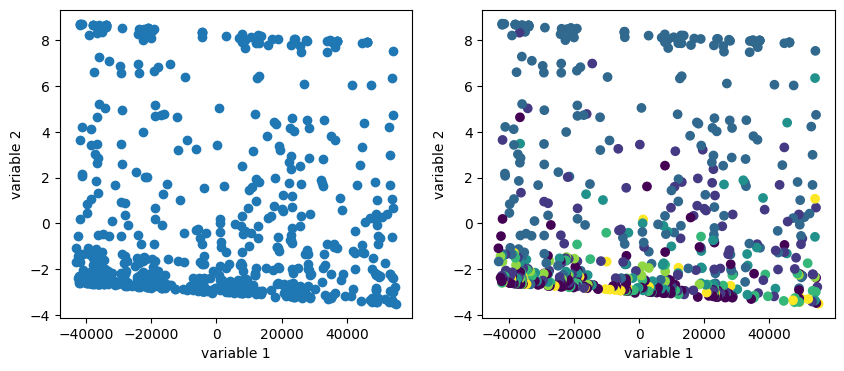

In [35]:
# PCA does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

### DBSCAN

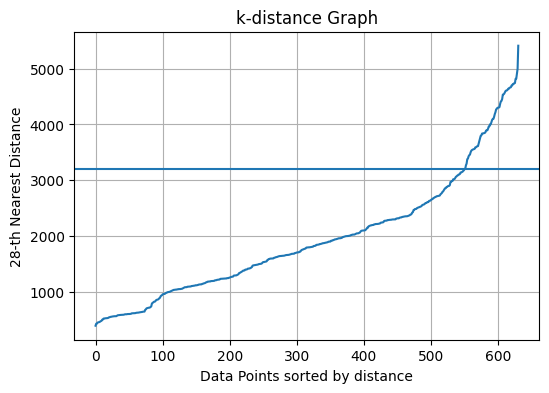

In [36]:
minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X_pc)
distances, indices = neigh.kneighbors(X_pc)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(3200)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 3200

In [37]:
from sklearn.cluster import DBSCAN

min_samples_ = [20, 25, 30, 35, 40, 45, 50, 55, 60]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=3200, min_samples=i).fit(X_pc)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 4
For min_samples: 30 Number of Clusters Predicted: 5
For min_samples: 35 Number of Clusters Predicted: 6
For min_samples: 40 Number of Clusters Predicted: 7
For min_samples: 45 Number of Clusters Predicted: 6
For min_samples: 50 Number of Clusters Predicted: 6
For min_samples: 55 Number of Clusters Predicted: 5
For min_samples: 60 Number of Clusters Predicted: 6


In [38]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X_pc, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_pc, cluster.labels_))
    db_.append(davies_bouldin_score(X_pc, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

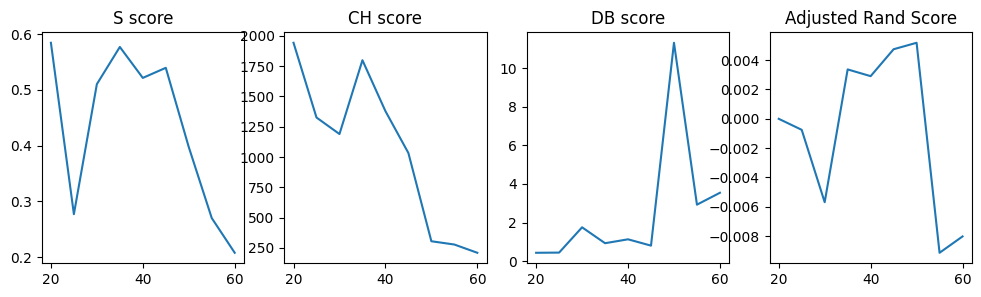

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

eps = 3200  and min_samples = 45 provides the second highest adjusted rand score, relatively high S score and relatively low DB score. 

In [40]:
final_dbscan = DBSCAN(eps=3200, min_samples=45).fit(X_pc)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X_pc, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_pc, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_pc, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.5394638690787681
Calinski Harabasz Score: 1032.4553148854764
Davies Bouldin Score: 0.8074343082653833
Adjusted Rand Index: 0.004734365656700725


In [41]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  6


#### Visualization of results

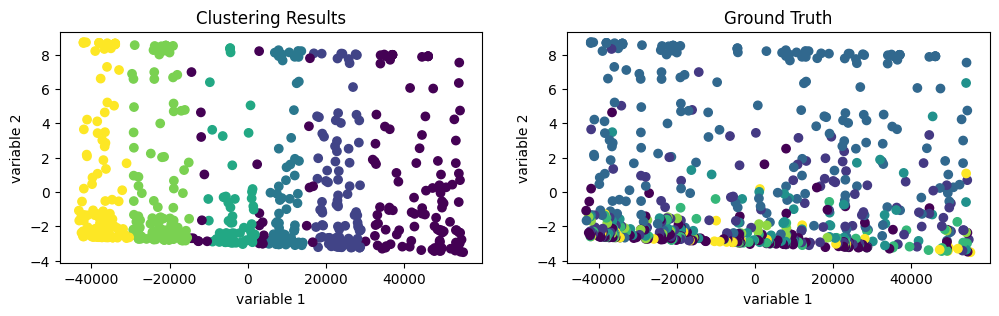

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=dbscan_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
plt.show()

### KMeans

In [43]:
n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X_pc)
    kmeans_.append(kmeans)

In [44]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X_pc, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_pc, cluster.labels_))
    db_.append(davies_bouldin_score(X_pc, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

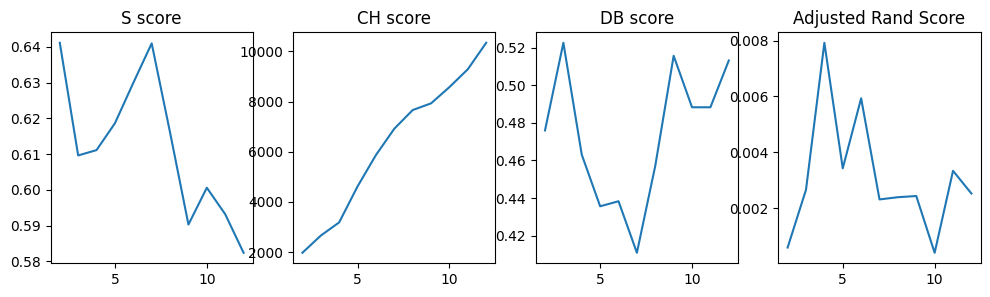

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 4 provides the highest Adjusted Rand Score, relatively high S Score and relatively low DB Score. 

In [46]:
final_kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(X_pc)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X_pc, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_pc, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_pc, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.6111153451079654
Calinski Harabasz Score: 3182.492919169511
Davies Bouldin Score: 0.4630051280259137
Adjusted Rand Index: 0.007922750053569605


#### Visualization of results

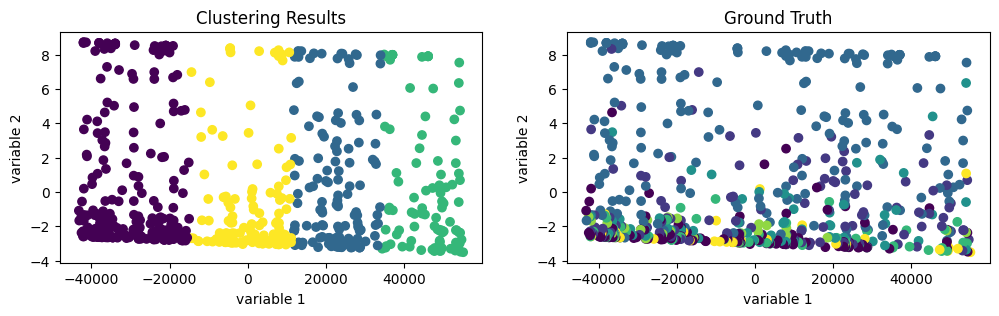

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
plt.show()

Clustering with and without PCA provides the same results and this is expected given that the 2 PCs we used explain 0.99999999 of the variance, ALMOST 1!!!

## Clustering Different Users (based on postal code) with t-SNE

In [48]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=70).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(631, 2)

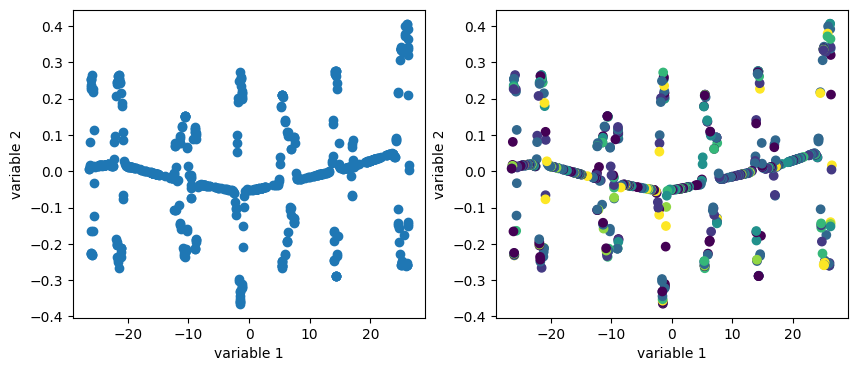

In [49]:
# t-SNE does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

### DBSCAN

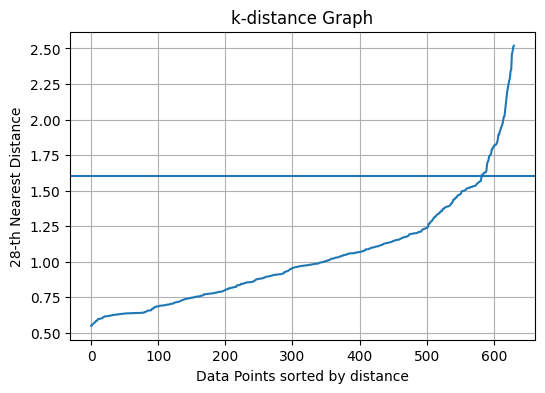

In [50]:
minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X_embedded)
distances, indices = neigh.kneighbors(X_embedded)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(1.6)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 1.6

In [51]:
min_samples_ = [20, 25, 30, 35, 40, 45, 50, 55, 60]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=1.6, min_samples=i).fit(X_embedded)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 5
For min_samples: 30 Number of Clusters Predicted: 7
For min_samples: 35 Number of Clusters Predicted: 8
For min_samples: 40 Number of Clusters Predicted: 7
For min_samples: 45 Number of Clusters Predicted: 7
For min_samples: 50 Number of Clusters Predicted: 8
For min_samples: 55 Number of Clusters Predicted: 7
For min_samples: 60 Number of Clusters Predicted: 2


In [52]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X_embedded, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_embedded, cluster.labels_))
    db_.append(davies_bouldin_score(X_embedded, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

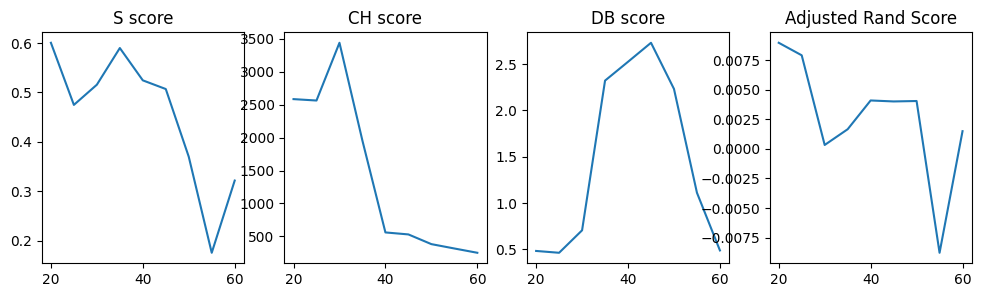

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

epsilon = 1.6 and min_samples = 20 has the highes adjuste rand score with highes s score, relatively high ch score and relatively low db score

In [54]:
final_dbscan = DBSCAN(eps=1.6, min_samples=20).fit(X_embedded)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X_embedded, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_embedded, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_embedded, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.6003738045692444
Calinski Harabasz Score: 2584.8256205462562
Davies Bouldin Score: 0.48224473877562657
Adjusted Rand Index: 0.008968013764245723


In [55]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  3


#### Visualization of results

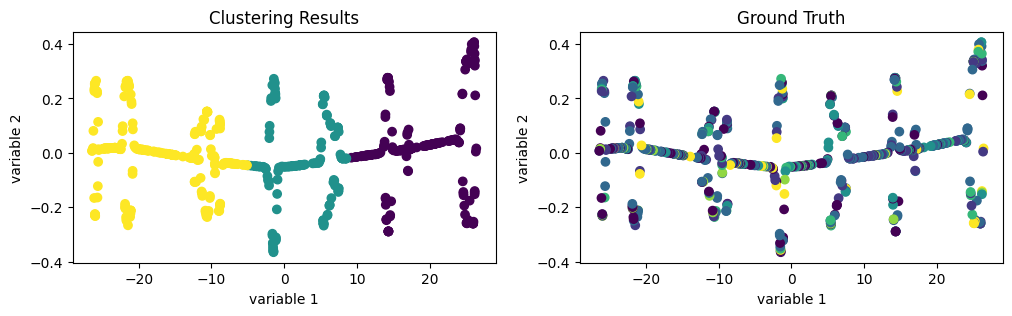

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=dbscan_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
plt.show()

### KMeans

In [57]:
n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X_embedded)
    kmeans_.append(kmeans)

In [58]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X_embedded, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_embedded, cluster.labels_))
    db_.append(davies_bouldin_score(X_embedded, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

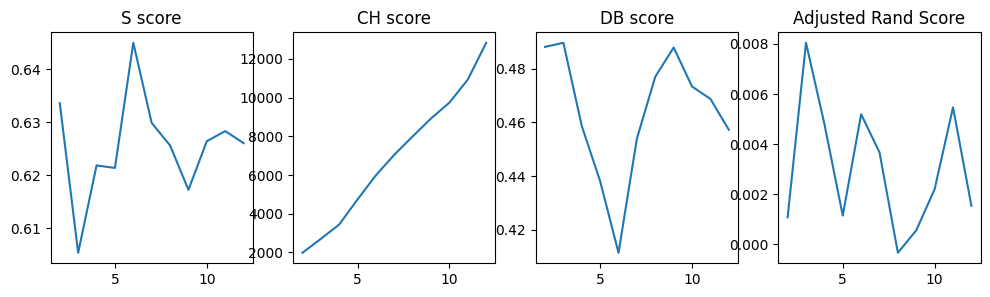

In [59]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 4 provides highest Adjusted Rand Score, relatively high S Score and relatively low DB Score. 

In [60]:
final_kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X_embedded, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_embedded, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_embedded, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.6218696236610413
Calinski Harabasz Score: 3441.667004526241
Davies Bouldin Score: 0.45866364395348114
Adjusted Rand Index: 0.004810904606846987


#### Visualization of results

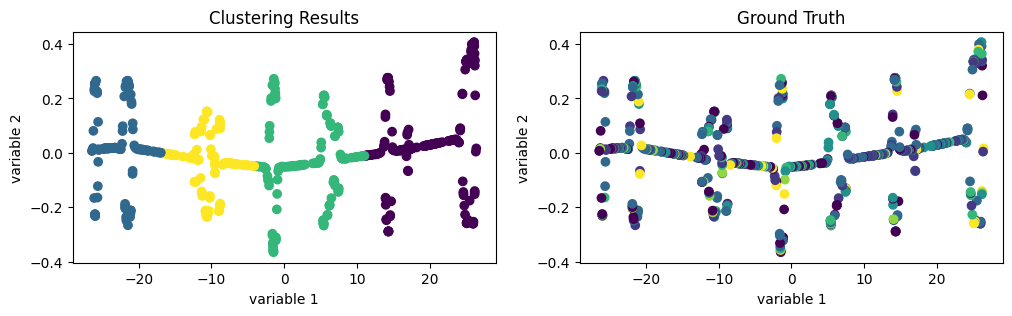

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
plt.show()

DBSCAN provide a slighly higher Adjusted Rand Index than KMeans which suggests that the 3 clusters formed by it are of slighlty closer similarity to the actual Labels than the 4 clusters formed by KMeans

Do note that all the adjusted rand index obtained are all lower than 0.01, which maybe caused by the wrong features extracted. 

## Improvement: extract frequent items as features per label

In [62]:
sparse_store_data_label = sparse_store_data.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
sparse_store_data_label.head()

,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables,Segment
Postal Code,,,,,,,,,,,,,,,,,,
1040,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Home Office
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,Corporate
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,Corporate
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,Corporate
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,Corporate


In [63]:
labelling = sparse_store_data_label.groupby('Postal Code')[['Segment']].agg(lambda x: ', '.join(sorted(set(x))))

le = LabelEncoder()
labelling['Label'] = le.fit_transform(labelling['Segment'])
print(len(labelling['Label'].unique()))

7


In [64]:
sparse_store_data_label = sparse_store_data_label.merge(labelling[['Label']], on='Postal Code').drop(['Segment'], axis=1)
sparse_store_data_label = sparse_store_data_label[~sparse_store_data_label.index.duplicated(keep='first')]
sparse_store_data_label.head()

,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables,Label
Postal Code,,,,,,,,,,,,,,,,,,
1040,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1
1752,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1810,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0
1841,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1,2


In [65]:
sparse_store_data_label.shape

(631, 18)

In [66]:
unique_labels = sorted(sparse_store_data_label['Label'].unique())

new_col = []
# changing the min_support just so that each label at least has some number of frequent itemset , can ommit this too
# adjust from 0.5
for i in unique_labels:
    if i == 1:
        min_support = 0.2
    elif i == 2:
        min_support = 0.55
    elif i == 3:
        min_support = 0.2
    else:
        min_support=0.1
    item_count = algorithm.apriori(df=sparse_store_data_label[sparse_store_data_label['Label']==i].drop('Label', axis=1), use_colnames=True, verbose=1, count=False, min_support=min_support)['itemsets'].unique().tolist()
    print(f"Label {i} has {len(item_count)} frequent items given a minimum support of {min_support}")
    new_col=new_col+item_count
print("Total number of frequent items: ", len(new_col))
new_col = list(set(new_col))
print("Total number of unique frequent items: ", len(new_col))

Processing 3 combinations | Sampling itemset size 32
Label 0 has 11 frequent items given a minimum support of 0.1
Processing 76 combinations | Sampling itemset size 43
Label 1 has 48 frequent items given a minimum support of 0.2
Processing 20 combinations | Sampling itemset size 54
Label 2 has 81 frequent items given a minimum support of 0.55
Processing 87 combinations | Sampling itemset size 3
Label 3 has 23 frequent items given a minimum support of 0.2
Processing 24 combinations | Sampling itemset size 3
Label 4 has 14 frequent items given a minimum support of 0.1
Processing 216 combinations | Sampling itemset size 3
Label 5 has 34 frequent items given a minimum support of 0.1
Processing 3 combinations | Sampling itemset size 32
Label 6 has 11 frequent items given a minimum support of 0.1
Total number of frequent items:  222
Total number of unique frequent items:  90


### Data Preprocessing for clustering users

In [67]:
new_df = pd.DataFrame(index=sparse_store_data_label.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data_label.index:
        for item in itemset:
            if sparse_store_data_label.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:56<00:00,  1.59it/s]


In [68]:
final_df = new_df.merge(sparse_store_data_label[['Label']], how='left', on='Postal Code')
print(final_df.shape)
final_df.head()

(631, 91)


,"(Storage, Art)","(Accessories, Furnishings)","(Binders, Bookcases)",(Binders),"(Accessories, Paper, Phones)","(Phones, Storage, Furnishings)","(Chairs, Paper)","(Binders, Storage, Paper, Art)","(Chairs, Phones)","(Binders, Chairs)",...,"(Accessories, Storage)","(Art, Furnishings)","(Binders, Paper, Art)","(Accessories, Storage, Binders)","(Binders, Paper, Phones, Furnishings)","(Appliances, Phones)","(Phones, Art, Furnishings)","(Binders, Paper, Furnishings)","(Accessories, Binders, Furnishings)",Label
Postal Code,,,,,,,,,,,,,,,,,,,,,
1040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1453,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1810,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1841,1,0,0,1,0,1,1,1,1,1,...,0,1,1,0,1,1,1,1,0,2


### Clustering Different Users (based on postal code)

#### DBSCAN

In [69]:
X = final_df.iloc[:, :-1]
X= X.rename(str,axis="columns") 

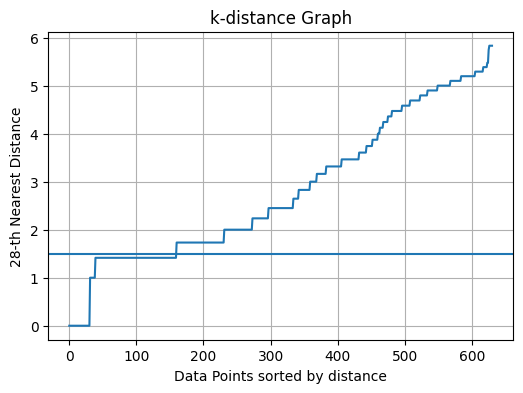

In [70]:
from sklearn.neighbors import NearestNeighbors

minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(1.5)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 1.5

In [71]:
from sklearn.cluster import DBSCAN

min_samples_ = [5, 10, 15, 20, 25, 30, 35, 40]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=1.5, min_samples=i).fit(X)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 5 Number of Clusters Predicted: 5
For min_samples: 10 Number of Clusters Predicted: 4
For min_samples: 15 Number of Clusters Predicted: 4
For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 3
For min_samples: 30 Number of Clusters Predicted: 3
For min_samples: 35 Number of Clusters Predicted: 3
For min_samples: 40 Number of Clusters Predicted: 3


In [72]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X, cluster.labels_))
    db_.append(davies_bouldin_score(X, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

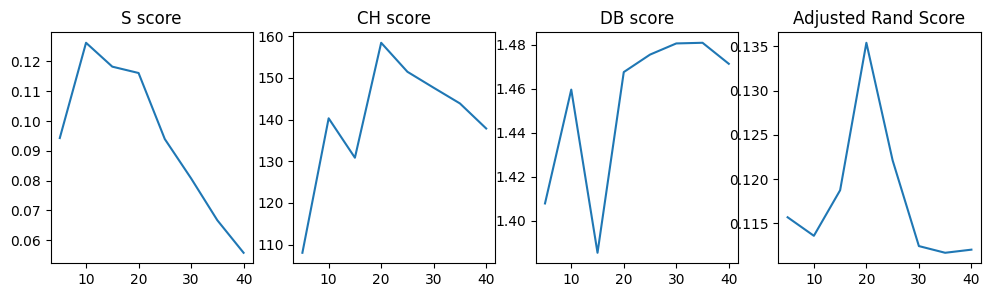

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

eps = 1.5  and min_samples = 20 provides the highest adjusted rand score, relatively high S score and highest CH score. 

In [74]:
final_dbscan = DBSCAN(eps=1.5, min_samples=20).fit(X)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.11611317699506365
Calinski Harabasz Score: 158.4290765984056
Davies Bouldin Score: 1.4676190787731367
Adjusted Rand Index: 0.13539564616212116


In [75]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  3


##### Reducing dimension with PCA for visualization of results

In [76]:
pca = PCA(n_components=2)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
X_pc = pd.DataFrame(pca.transform(X))

0.5899382565902304


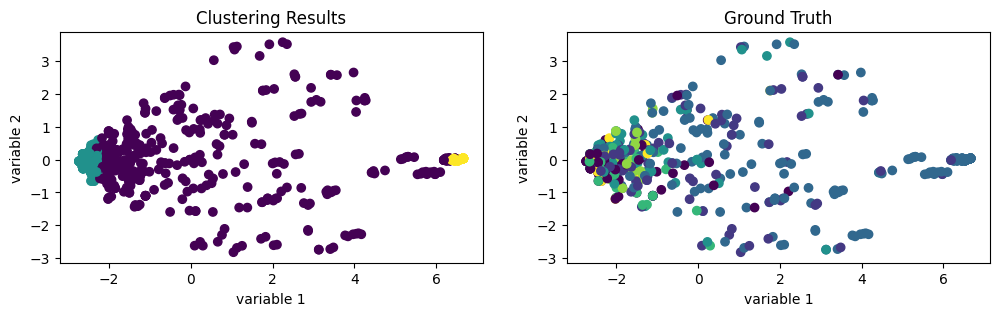

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=dbscan_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
plt.show()

#### KMeans

In [78]:
n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X)
    kmeans_.append(kmeans)

In [79]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X, cluster.labels_))
    db_.append(davies_bouldin_score(X, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

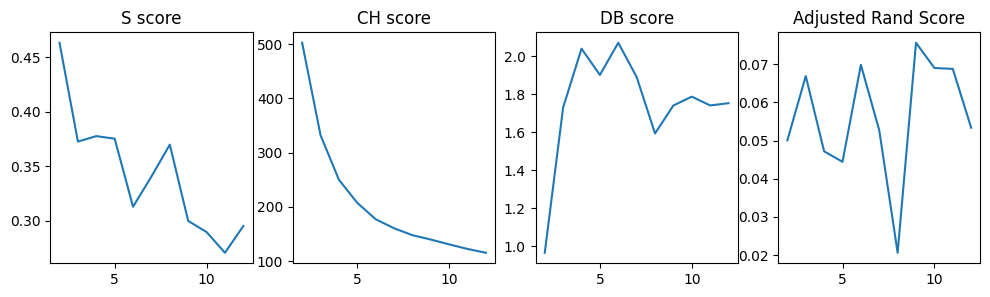

In [80]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 6 provides the highest Adjusted Rand Score. 

In [81]:
final_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++').fit(X)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.31276121942976465
Calinski Harabasz Score: 177.2852383749105
Davies Bouldin Score: 2.071808057208545
Adjusted Rand Index: 0.069854218184954


##### Reducing dimension with PCA for visualization of results

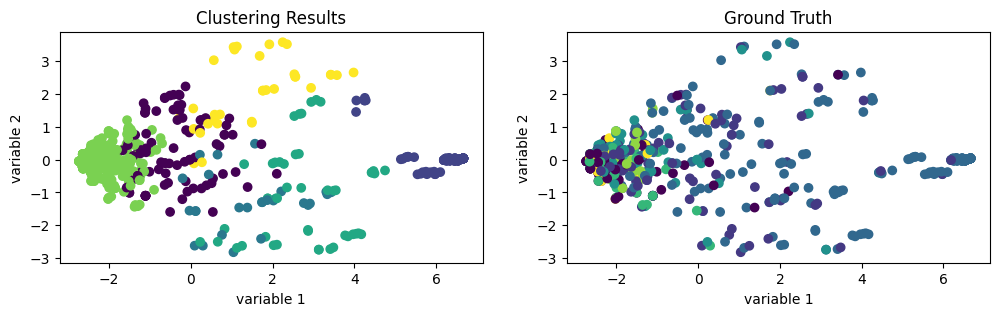

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
plt.show()

DBSCAN provide a higher Adjusted Rand Index than KMeans which suggests that the 3 clusters formed by it are of closer similarity to the actual Labels than the 6 clusters formed by KMeans

### Clustering Different Users (based on postal code) with PCA

In [83]:
pca = PCA(n_components=8)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
X_pc = pd.DataFrame(pca.transform(X))

0.80803356623108


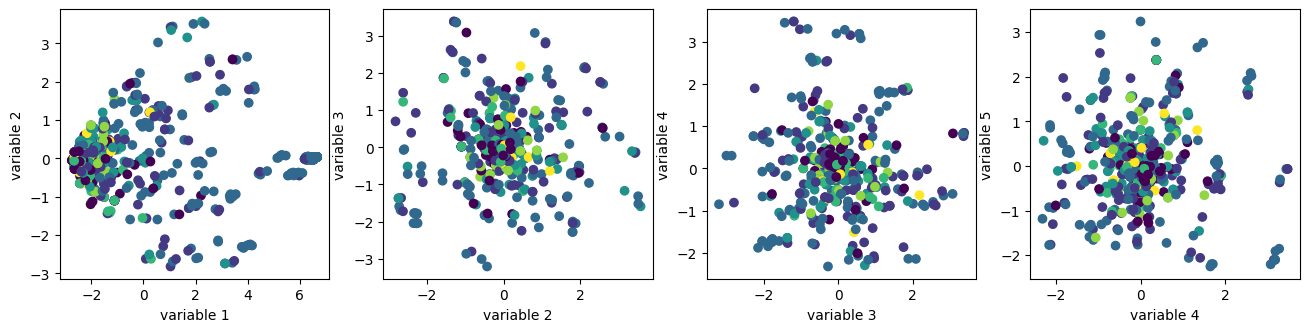

In [84]:
# PCA does not result in clear clusters too

fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_pc.iloc[:, 1], y=X_pc.iloc[:, 2], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 2")
axes[1].set_ylabel("variable 3")
axes[2].scatter(x=X_pc.iloc[:, 2], y=X_pc.iloc[:, 3], c=final_df['Label'], cmap='viridis')
axes[2].set_xlabel("variable 3")
axes[2].set_ylabel("variable 4")
axes[3].scatter(x=X_pc.iloc[:, 3], y=X_pc.iloc[:, 4], c=final_df['Label'], cmap='viridis')
axes[3].set_xlabel("variable 4")
axes[3].set_ylabel("variable 5")
plt.show()

#### DBSCAN

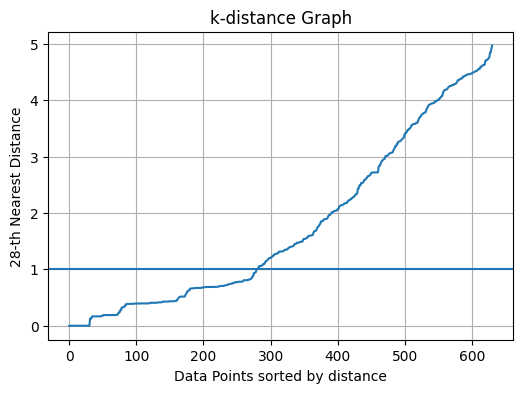

In [85]:
minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X_pc)
distances, indices = neigh.kneighbors(X_pc)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(1)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 1

In [86]:
min_samples_ = [5, 10, 15, 20, 25, 30, 35, 40]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=1, min_samples=i).fit(X_pc)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 5 Number of Clusters Predicted: 9
For min_samples: 10 Number of Clusters Predicted: 4
For min_samples: 15 Number of Clusters Predicted: 3
For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 3
For min_samples: 30 Number of Clusters Predicted: 3
For min_samples: 35 Number of Clusters Predicted: 3
For min_samples: 40 Number of Clusters Predicted: 3


In [87]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X_pc, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_pc, cluster.labels_))
    db_.append(davies_bouldin_score(X_pc, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

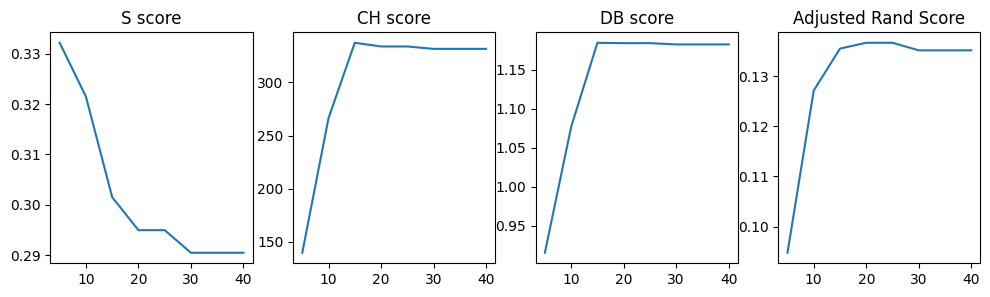

In [88]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

eps = 1  and min_samples = 20 provides relatively high adjusted rand score, relatively high CH score. 

In [89]:
final_dbscan = DBSCAN(eps=1, min_samples=20).fit(X_pc)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X_pc, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_pc, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_pc, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.2949439036335648
Calinski Harabasz Score: 333.78258868539524
Davies Bouldin Score: 1.184302753217753
Adjusted Rand Index: 0.13665217035455537


In [90]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  3


##### Visualization of results

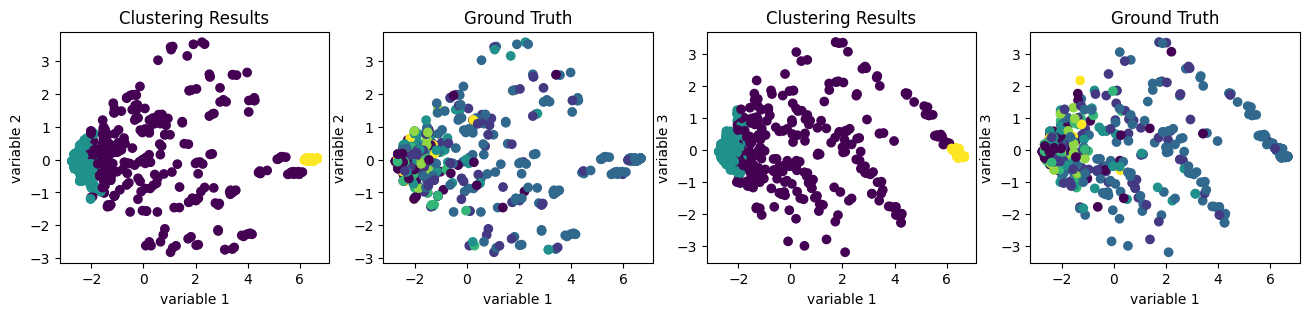

In [91]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3))

axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=dbscan_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
axes[2].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 2], c=dbscan_results, cmap='viridis')
axes[2].set_xlabel("variable 1")
axes[2].set_ylabel("variable 3")
axes[2].set_title("Clustering Results")
axes[3].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 2], c=final_df['Label'], cmap='viridis')
axes[3].set_xlabel("variable 1")
axes[3].set_ylabel("variable 3")
axes[3].set_title("Ground Truth")
plt.show()

#### KMeans

In [92]:
n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X_pc)
    kmeans_.append(kmeans)

In [93]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X_pc, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_pc, cluster.labels_))
    db_.append(davies_bouldin_score(X_pc, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

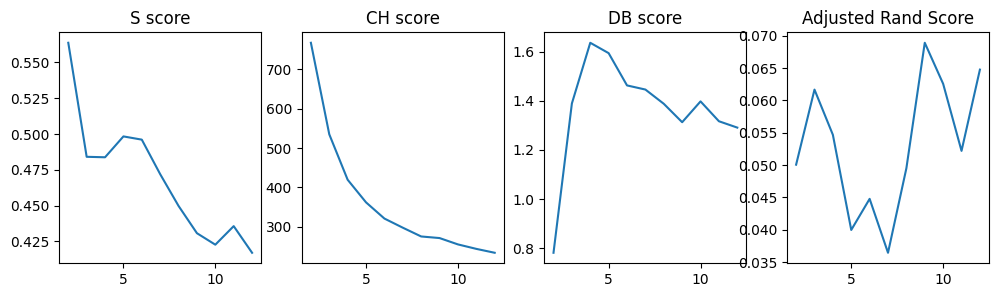

In [94]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 3 provides relatively high Adjusted Rand Score and relatively high S Score. 

In [95]:
final_kmeans = KMeans(n_clusters=3, random_state=0, init='k-means++').fit(X_pc)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X_pc, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_pc, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_pc, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.48406612926186227
Calinski Harabasz Score: 534.611420586528
Davies Bouldin Score: 1.3892051054040604
Adjusted Rand Index: 0.06166899337048065


##### Visualization of results

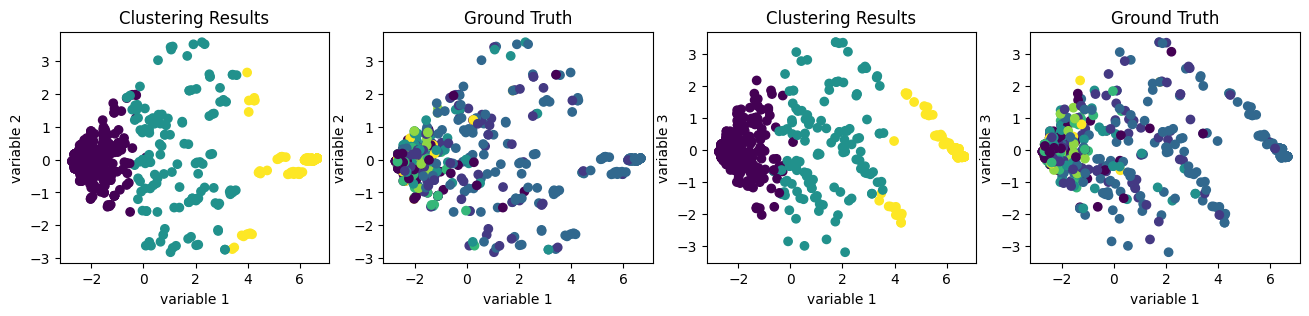

In [96]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3))

axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Clustering Results")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Ground Truth")
axes[2].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 2], c=kmeans_results, cmap='viridis')
axes[2].set_xlabel("variable 1")
axes[2].set_ylabel("variable 3")
axes[2].set_title("Clustering Results")
axes[3].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 2], c=final_df['Label'], cmap='viridis')
axes[3].set_xlabel("variable 1")
axes[3].set_ylabel("variable 3")
axes[3].set_title("Ground Truth")
plt.show()

DBSCAN provide a higher Adjusted Rand Index than KMeans which suggests that the 3 clusters formed by it are of closer similarity to the actual Labels than the 3 clusters formed by KMeanas

### Clustering Different Users (based on postal code) with t-SNE

In [97]:
X_embedded = TSNE(n_components=2, init='pca', perplexity=35).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(631, 2)

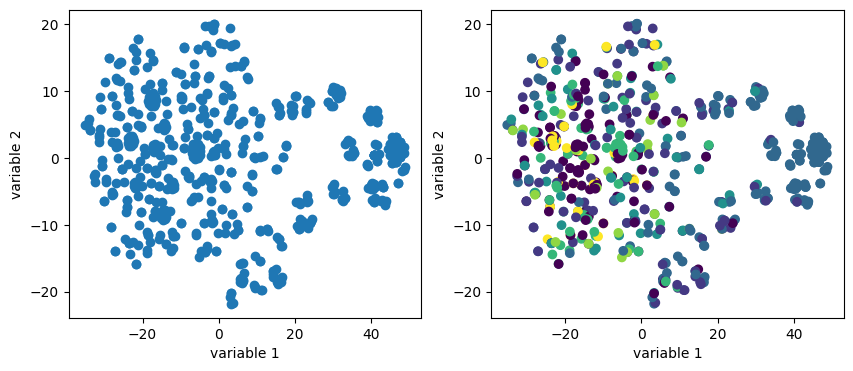

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

#### DBSCAN

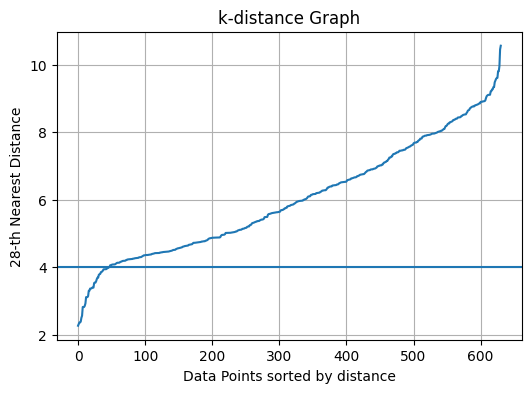

In [99]:
minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X_embedded)
distances, indices = neigh.kneighbors(X_embedded)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(4)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 4

In [100]:
min_samples_ = [5, 10, 15, 20, 25, 30, 35]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=4, min_samples=i).fit(X_embedded)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 5 Number of Clusters Predicted: 7
For min_samples: 10 Number of Clusters Predicted: 9
For min_samples: 15 Number of Clusters Predicted: 9
For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 5
For min_samples: 30 Number of Clusters Predicted: 4
For min_samples: 35 Number of Clusters Predicted: 2


In [101]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X_embedded, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_embedded, cluster.labels_))
    db_.append(davies_bouldin_score(X_embedded, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

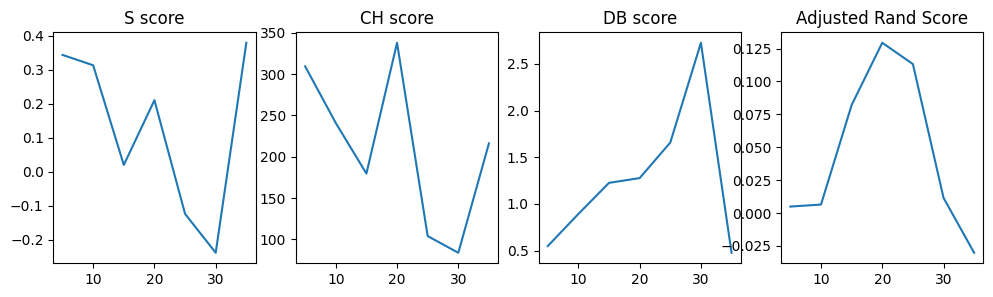

In [102]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

epsilon = 4 and min_samples = 20 has the highes adjuste rand score with relatively high ch score and relatively low db score

In [103]:
final_dbscan = DBSCAN(eps=4, min_samples=20).fit(X_embedded)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X_embedded, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_embedded, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_embedded, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.21081779897212982
Calinski Harabasz Score: 337.92999869051835
Davies Bouldin Score: 1.2764331619813984
Adjusted Rand Index: 0.12940571815231836


In [104]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  3


##### Visualization of results

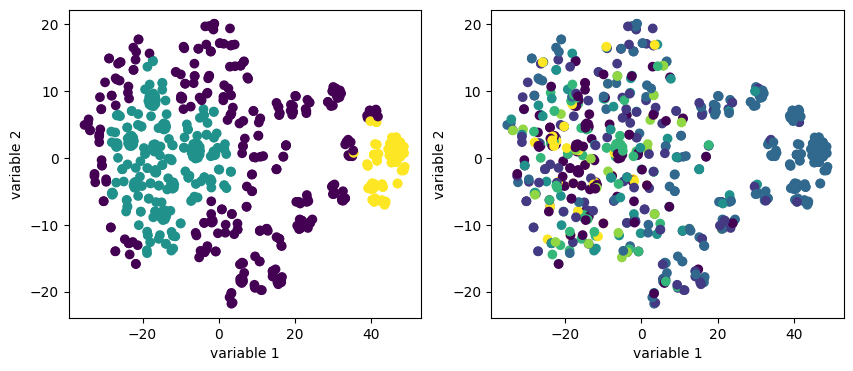

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=dbscan_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

#### KMeans

In [106]:
n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X_embedded)
    kmeans_.append(kmeans)

In [107]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X_embedded, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_embedded, cluster.labels_))
    db_.append(davies_bouldin_score(X_embedded, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

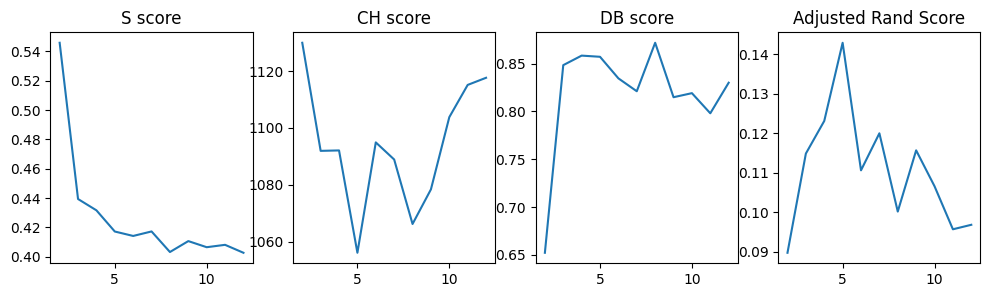

In [108]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 6 provides highest Adjusted Rand Score. 

In [109]:
final_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X_embedded, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_embedded, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_embedded, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.4140875041484833
Calinski Harabasz Score: 1094.8868248631438
Davies Bouldin Score: 0.8345167135228078
Adjusted Rand Index: 0.11060263354239741


##### Visualization of results

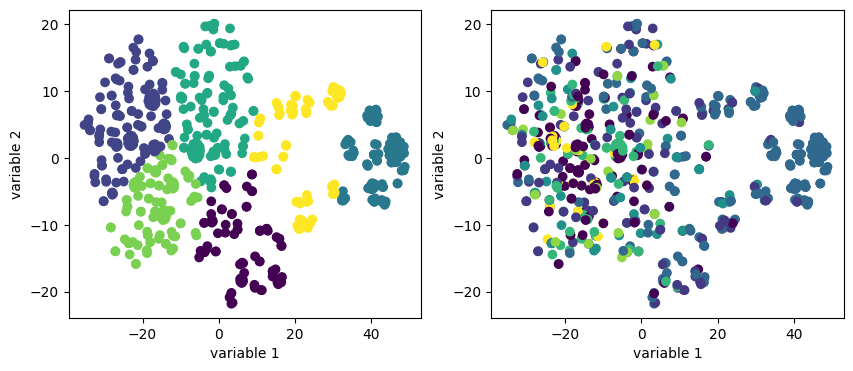

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

KMeans provide a slighly higher Adjusted Rand Index than DBSCAN which suggests that the 6 clusters formed by it are of slighlty closer similarity to the actual Labels than the 5 clusters formed by DBSCAN